In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, Concatenate, BatchNormalization, Input, LSTM, Dense
from tensorflow.keras.regularizers import L1, L2

INPUT_DIM = 30
N_FEATURES = 50
OUTPUT_DIM = 32

# Generation of test MTS

Let's build a very simple MTS, which has 50 features, one of them, the first one, can be white noise or a sine wave. The rest of them, will be white noise. If the first feature is a sine wave then the label will be one, if it is not the case then its label will be a zero. So we have a simple classification task, where the  **Neural Feature Selector** should give the maximum feature importance to this first feature.

In [2]:
np.random.seed(1456)

In [3]:
mts = np.random.randn(5000, INPUT_DIM, N_FEATURES)

In [4]:
labels = []
for idx, _ in enumerate(mts):
    if np.random.randint(2, size=1)[0]:
        mts[idx, :, 0] = np.sin([x for x in range(INPUT_DIM)])
        labels.append(1)
    else:
        labels.append(0)

labels = np.array(labels).reshape(-1, 1)

##### Example of positive class (we just show the first 4 features)

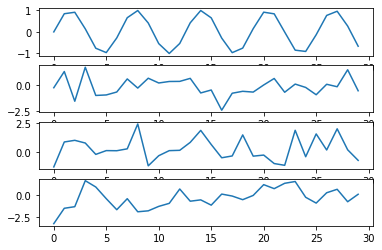

In [5]:
fig, axs = plt.subplots(4, 1)

axs[0].plot(mts[0, :, 0])
axs[1].plot(mts[0, :, 1])
axs[2].plot(mts[0, :, 2])
axs[3].plot(mts[0, :, 3])

##### Example of negative class (we just show the first 4 features)

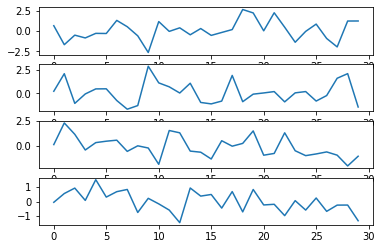

In [6]:
fig, axs = plt.subplots(4, 1)

axs[0].plot(mts[2, :, 0])
axs[1].plot(mts[2, :, 1])
axs[2].plot(mts[2, :, 2])
axs[3].plot(mts[2, :, 3])

# Neural Feature Selector

Implementation of the NFS as seen in `neural_feature_selector.py`.

In [7]:
def aggregating_cnn(inputs, n_filters):
    return Conv1D(filters=n_filters,
                  kernel_size=1,
                  padding="same",
                  strides=1,
                  dilation_rate=1,
                  activation="relu",
                  kernel_regularizer=L1(0.01))(inputs)


def tcnn_block(inputs, kernel_sizes=None):
    """
    Applies Conv1D to a feature in the input MTS (a feature is just a univariant TS)

    Args:
        inputs: A Tensor representing a MTS
        kernel_sizes: The Kernel Sizes of each Conv1D (there will be only one filter for each kernel_size)

    Returns:
        The encoded features
    """
    if kernel_sizes is None:
        kernel_sizes = [2, 3, 4, 5]

    inputs = tf.expand_dims(inputs, axis=-1)
    x = Concatenate(axis=-1)(
      [Conv1D(filters=1,
              kernel_size=x,
              padding="same",
              strides=1,
              dilation_rate=1,
              activation="relu",
              kernel_regularizer=L2(0.01))(inputs) for x in kernel_sizes])
    x = aggregating_cnn(x, n_filters=1)
    return x


def tcnn_layer(inputs, n_features):
    """
    The TCNN layer applies a `tcnn_block` to each feature and then concatenates the output tensors
    by the last axis.

    Args:
        inputs: A MTS
        n_features: The number of features

    Returns:

    """
    return Concatenate(axis=-1)([tcnn_block(inputs[..., x]) for x in range(n_features)])


def nfs(inputs, input_shape, n_output_filters):
    """

    Args:
        inputs: A MTS
        input_shape: MTS input shape
        n_output_filters: The number of output filters to apply in the aggregating cnn

    Returns:
        A new MTS after Neural Feature Selector is applied. This MTS will be the output for
        other architectures: LSTM, Resnet, ...
    """
    _, m = input_shape

    x = tcnn_layer(inputs, m)
    x = BatchNormalization()(x)
    return aggregating_cnn(x, n_filters=n_output_filters)

# NFS + LSTM

For demonstration purposes, we are going to plug a LSTM Cell after the NFS head.

In [8]:
inputs = Input(shape=(INPUT_DIM, N_FEATURES))
encoded_features = nfs(inputs, mts.shape[1:], 32)

whole_seq_output, _, _ = LSTM(32, return_sequences=False, return_state=True)(encoded_features)
outputs = Dense(1, activation="sigmoid")(whole_seq_output)

In [9]:
model = Model(inputs, outputs)

As stated in the paper, we need to "customize" our loss function, adding a lasso penalty over the BatchNormalization **alpha** params (in Tensorflow, they are called `gamma`).

In [10]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

def custom_loss_function(y_true, y_pred):
    return binary_cross_entropy(y_true, y_pred) + 0.001 * tf.math.reduce_sum(tf.abs(model.get_layer("batch_normalization").weights[0]))

In [11]:
model.compile("adam", custom_loss_function)
model.fit(mts, labels, verbose=0, batch_size=128, epochs=100, validation_split=0.2)

# Feature Importance

As we can see, all the feature importance is given to the first feature.

In [12]:
feature_importance = model.get_layer("batch_normalization").weights[0].numpy()

In [13]:
bar_indices = [x for x in range(len(feature_importance))]

<BarContainer object of 50 artists>

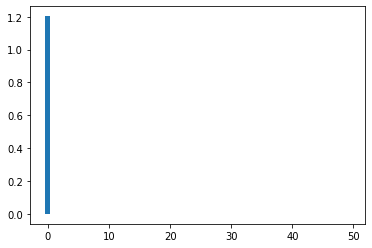

In [14]:
plt.bar(bar_indices, feature_importance)